In [ ]:
# To comment when on colab
# %load_ext autoreload
# %autoreload 2

### SetUp

In [1]:
!git clone https://github.com/InesVATI/active_contour_cnn.git

%cd active_contour_cnn/src

Cloning into 'active_contour_cnn'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 1), reused 23 (delta 1), pack-reused 0
Receiving objects: 100% (23/23), 681.52 KiB | 5.88 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/active_contour_cnn/src


In [2]:
%ls

datasets.py  experiments.ipynb  models.py


In [3]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 895.1 kB/s eta 0:00:00


In [1]:
import pydicom as dicom
import torch
from torch.utils.data import DataLoader, random_split
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy import ndimage


from models import LayerFCN8
from datasets import save_multilayer_label_map, CHAOSDataset

root_dir = os.path.dirname(os.getcwd())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device :', device)

device : cpu


In [5]:
# Download data
data_folder = '{}/__data/'.format(root_dir)
if not os.path.exists(data_folder):
  !gdown --fuzzy 'https://drive.google.com/file/d/15GedlUNuP57IisUftw-iywgCdI8hMcNA/view?usp=sharing' -O $data_folder

Downloading...
From (original): https://drive.google.com/uc?id=15GedlUNuP57IisUftw-iywgCdI8hMcNA
From (redirected): https://drive.google.com/uc?id=15GedlUNuP57IisUftw-iywgCdI8hMcNA&confirm=t&uuid=5c28dd6a-3627-44b4-815e-9b5bd95cff11
To: /content/active_contour_cnn/__data/Train_Sets.zip
100% 813M/813M [00:04<00:00, 196MB/s]


In [6]:
if os.path.exists(f'{root_dir}/__data/Train_Sets.zip'):
  file_path = f'{root_dir}/__data/Train_Sets.zip'
  !unzip $file_path -d $data_folder
else :
  print('Issue while downloading data')

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/active_contour_cnn/__data/Train_Sets/CT/22/Layer_label_map/GT_map_025.npy  
  inflating: /content/active_contour_cnn/__data/Train_Sets/CT/22/Layer_label_map/GT_map_026.npy  
  inflating: /content/active_contour_cnn/__data/Train_Sets/CT/22/Layer_label_map/GT_map_027.npy  
  inflating: /content/active_contour_cnn/__data/Train_Sets/CT/22/Layer_label_map/GT_map_028.npy  
  inflating: /content/active_contour_cnn/__data/Train_Sets/CT/22/Layer_label_map/GT_map_029.npy  
  inflating: /content/active_contour_cnn/__data/Train_Sets/CT/22/Layer_label_map/GT_map_030.npy  
  inflating: /content/active_contour_cnn/__data/Train_Sets/CT/22/Layer_label_map/GT_map_031.npy  
  inflating: /content/active_contour_cnn/__data/Train_Sets/CT/22/Layer_label_map/GT_map_032.npy  
  inflating: /content/active_contour_cnn/__data/Train_Sets/CT/22/Layer_label_map/GT_map_033.npy  
  inflating: /content/active_contour_cnn

In [2]:
data_folder = os.path.join(root_dir, '__data', 'Train_Sets', 'CT')

## Visualize generated layer label map

In [94]:
save_multilayer_label_map(data_folder, d=5)

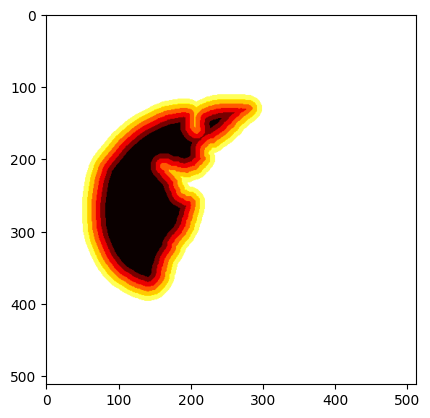

In [98]:
with open(os.path.join(data_folder, '5', 'Layer_label_map', 'GT_map_060.npy'), 'rb') as f:
    label_map = np.load(f)

plt.imshow(label_map, cmap='hot')          

91
Img id  5
Input image shape (512, 512) min 0 max 2285
Label size : (512, 512); type float64; min : 0.0; max : 1.0; mean : 0.027873992919921875
pixel spacing [0.791015625, 0.791015625]
Img id  60
Input image shape (512, 512) min 0 max 2189
Label size : (512, 512); type float64; min : 0.0; max : 1.0; mean : 0.051792144775390625
pixel spacing [0.791015625, 0.791015625]


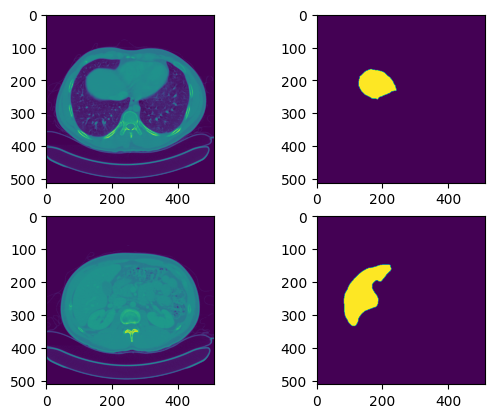

In [80]:
patient_id = 0
a=300
for i, patient_id in enumerate([3, 5]):
    img_id = [5, 60]
    files = sorted(os.listdir(data_folder))

    dicom_files = sorted(os.listdir(f"{data_folder}/{files[patient_id]}/DICOM_anon"))
    ground_files = sorted(os.listdir(f"{data_folder}/{files[patient_id]}/Ground"))
    print(len(dicom_files))
    ds0 = dicom.dcmread(os.path.join(data_folder, files[patient_id], 'DICOM_anon', dicom_files[img_id[0]]))
    label_map0 = Image.open(os.path.join(data_folder, files[patient_id], 'Ground', ground_files[img_id[0]]))
    label_map0 = np.array(label_map0).astype(float)
    print("Img id ", img_id[0])
    print('Input image shape', ds0.pixel_array.shape, 'min', ds0.pixel_array.min(), 'max', ds0.pixel_array.max())
    print(f"Label size : {label_map0.shape}; type {label_map0.dtype}; min : {label_map0.min()}; max : {label_map0.max()}; mean : {label_map0.mean()}")
    print('pixel spacing', ds0.PixelSpacing)

    ds1 = dicom.dcmread(os.path.join(data_folder, files[patient_id], 'DICOM_anon', dicom_files[img_id[1]]))
    label_map1 = Image.open(os.path.join(data_folder, files[patient_id], 'Ground', ground_files[img_id[1]]))
    label_map1 = np.array(label_map1).astype(float)
    print("Img id ", img_id[1])
    print('Input image shape', ds1.pixel_array.shape, 'min', ds1.pixel_array.min(), 'max', ds1.pixel_array.max())
    print(f"Label size : {label_map1.shape}; type {label_map1.dtype}; min : {label_map1.min()}; max : {label_map1.max()}; mean : {label_map1.mean()}")
    print('pixel spacing', ds1.PixelSpacing)

    # img0 = ( ds0.pixel_array - ds0.pixel_array.min()) / (ds0.pixel_array.max() - ds0.pixel_array.min())
    # img1 = ( ds1.pixel_array - ds1.pixel_array.min()) / (ds1.pixel_array.max() - ds1.pixel_array.min())

    fig = plt.figure()
    fig.add_subplot(2, 2, 1)
    plt.imshow(ds0.pixel_array) # , cmap='gray'
    fig.add_subplot(2, 2, 2)
    plt.imshow(label_map0)

    fig.add_subplot(2, 2, 3)
    plt.imshow(ds1.pixel_array)
    fig.add_subplot(2, 2, 4)
    plt.imshow(label_map1)

    plt.show()
    break

Distance to background : min : -45.17742799230607; max : 406.06034034364893


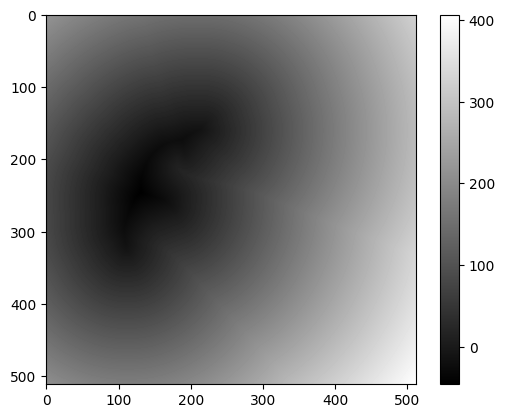

In [81]:
signed_dist = ndimage.distance_transform_edt(1 - label_map1) - ndimage.distance_transform_edt(label_map1)
print(f"Distance to background : min : {signed_dist.min()}; max : {signed_dist.max()}")

plt.imshow(signed_dist, cmap='gray')
plt.colorbar()

plt.show()


Delta : 6.320987654320987
Label -3 size : 5798
Label 3 size : 239243
Label -2 size : 2918
Label -1 size : 2626
Label 0 size : 4575
Label 1 size : 3064
Label 2 size : 3920


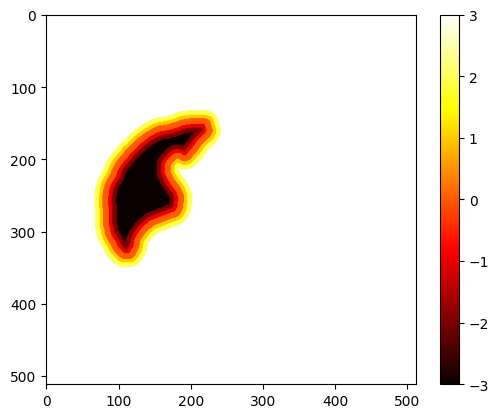

In [90]:
d = 5
delta = d / ds1.PixelSpacing[0]
print(f"Delta : {delta}")
N = 4
layer_label_map = np.zeros_like(label_map1)
layer_label_map[ signed_dist <= (- N+2 - 0.5)*delta] = -N+1
print(f"Label {-N+1} size : {np.sum(layer_label_map == -N+1)}")
layer_label_map[ signed_dist > (N - 1.5)*delta] = N-1
print(f"Label {N-1} size : {np.sum(layer_label_map == N-1)}")
a = 1.4
for i in range(-N+2, N-1):
    if i==0:
        cond = ((i-0.5)*(delta*a) < signed_dist) & (signed_dist <= (i+0.5)*(delta*a))
    elif i==-1:
        cond = ((i-0.5)*delta < signed_dist) & (signed_dist <= (i+0.5)*(a*delta))
    elif i==1:
        cond = ((i-0.5)*(delta*a) < signed_dist) & (signed_dist <= (i+0.5)*delta)
    else :
        cond = ((i-0.5)*delta < signed_dist) & (signed_dist <= (i+0.5)*delta)
    layer_label_map[cond] = i
    print(f'Label {i} size : {np.sum(cond)}')


fig = plt.figure()
plt.imshow(layer_label_map, cmap='hot') # [100:300, 100:300]
plt.colorbar()
plt.show()

In [86]:
512*512

262144

In [85]:
(layer_label_map == 3).sum()

239243

(512, 512)


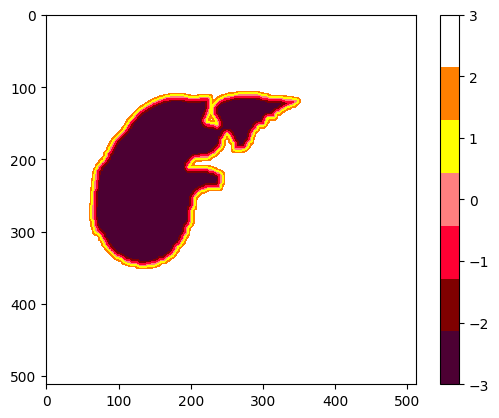

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

layer_label_map = np.load(os.path.join(data_folder, '8', 'Layer_label_map', 'GT_map_050.npy'))
print(layer_label_map.shape)

colors = [(0.3, 0, 0.2), (0.5, 0, 0), (1, 0, 0.2), (1, 0.5, 0.5), (1, 1, 0), (1, .5, 0), (1, 1, 1)] #  (.5, .5, 1),
cmap_name = 'my_list'
n_bin = 7

cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)

fig, ax = plt.subplots()
im = ax.imshow(layer_label_map, cmap=cmap)

fig.colorbar(im, ax=ax)

plt.show()

## Get familiar with convolutions

In [ ]:
# inp = torch.randn(1, 16, 12, 12)

# downsample = torch.nn.Conv2d(16, 16, 3, stride=2, padding=0)
# upsample = torch.nn.ConvTranspose2d(16, 16, 3, stride=2, padding=0)

# out = downsample(inp)
# print(out.shape)
# out = upsample(out)
# print(out.shape)

c:\Users\INES\Documents\3A_MVA\DeformableModelsGeodesics\active_contour_cnn/__data/Train_Sets/CT
img torch.Size([512, 512])


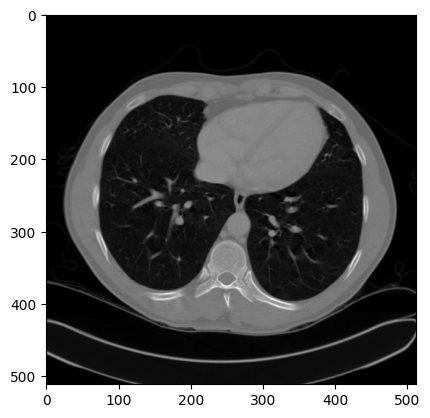

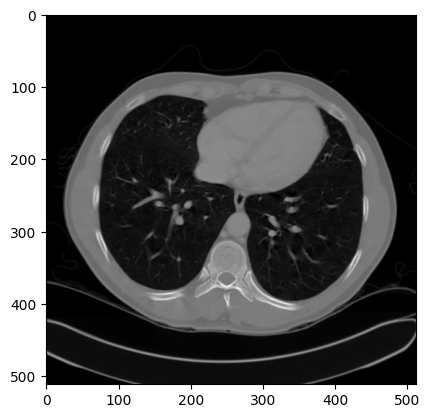

In [ ]:
data_folder = root_dir + '/__data/Train_Sets/CT'
print(data_folder)

patient = 8
dicom_files = os.listdir(f"{data_folder}/{patient}/DICOM_anon/")
with open(f"{data_folder}/{patient}/DICOM_anon/{dicom_files[0]}", 'rb') as file:
    ds = dicom.dcmread(file)

img = torch.tensor(ds.pixel_array.astype(np.float32))
img = (img - img.min()) / (img.max() - img.min())
print('img', img.shape)
plt.imshow(img, cmap='gray')
plt.show()

# .view(1, *img.shape)
imgRGB = img.expand(3, -1, -1).contiguous() # expand better for memory than repeat
plt.imshow(imgRGB.permute(1, 2, 0))
plt.show()

In [ ]:
data = CHAOSDataset(data_folder)

In [ ]:
nb_data = len(data)
print(nb_data)

2066


In [ ]:
i = np.random.randint(0, nb_data)
inp, target = data[i]
print('inp', inp.shape)
print('target', target.shape)

inp torch.Size([3, 512, 512])
target (512, 512)


In [ ]:
target = torch.tensor(target + target.max() + 1, dtype=torch.float32)

In [ ]:
torch.unique(target)

tensor([1., 2., 3., 4., 5., 6., 7.])

## Train FCN

In [8]:
# download model pretrained weights file
result_folder =f'{root_dir}/__results/'
!gdown --fuzzy 'https://drive.google.com/file/d/1T2v4kdTY9l2drUooRGendYWoEgRvBeL6/view?usp=sharing' -O $result_folder

Downloading...
From (original): https://drive.google.com/uc?id=1T2v4kdTY9l2drUooRGendYWoEgRvBeL6
From (redirected): https://drive.google.com/uc?id=1T2v4kdTY9l2drUooRGendYWoEgRvBeL6&confirm=t&uuid=78a0f3eb-4ea8-4a58-8ed3-edc21acc5112
To: /content/active_contour_cnn/__results/fcn8s-heavy-pascal.pth
100% 538M/538M [00:06<00:00, 86.8MB/s]


In [9]:
dataset = CHAOSDataset(data_folder)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.95, 0.03, .02])

print(f'Nb train data : {len(train_dataset)}\n'
      f'Nb val data : {len(val_dataset)}\n'
      f'Nb test data : {len(test_dataset)}\n')


Nb train data : 1963
Nb val data : 62
Nb test data : 41



In [10]:
class EarlyStopping:
    def __init__(self, patience:int=5, min_delta:float = 1e-3):
        self.patience = patience
        self.min_delta = min_delta
        self.prev_loss = None
        self.counter = 0

    def __call__(self, val_loss : float):

        if self.prev_loss is None:
            self.prev_loss = val_loss
            return False

        if np.abs(self.prev_loss - val_loss) < self.min_delta:
            self.counter += 1
        else:
            self.counter = 0

        self.prev_loss = val_loss

        if self.counter >= self.patience:
            return True

        return False


In [23]:
t[0].unique()

tensor([0, 1, 2, 3, 4, 5, 6])

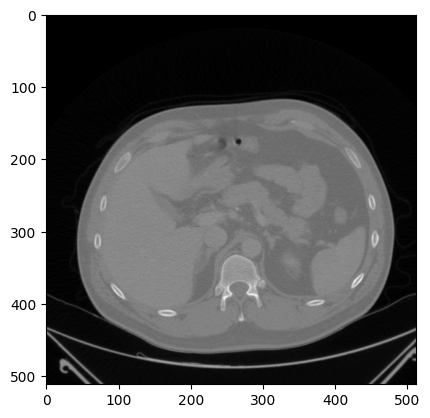

In [25]:
plt.imshow(x[0].permute(1, 2, 0))

In [ ]:
modelFCN = LayerFCN8(7, path_to_pretrained_folder=os.path.join(root_dir, '__results'))
modelFCN = modelFCN.to(device)

# freeze pretrained layers
for name, param in modelFCN.named_parameters():
    if 'score' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
modelFCN.score_fr.weight.data

In [31]:
modelFCN.upscore2.weight.data

tensor([[[[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5

In [32]:
x, t = next(iter(train_loader))
out = modelFCN(x.to(device))

In [35]:
def train(model : torch.nn.Module, optimizer : torch.optim,
          train_dataloader : DataLoader, val_dataloader : DataLoader,
          lr_scheduler : torch.optim.lr_scheduler = None,
          early_stopper : EarlyStopping = None,
          nepochs_max:int=100):

    criterion = torch.nn.CrossEntropyLoss()
    train_loss, val_loss = [], []

    for epoch in range(nepochs_max):
        bs_train_loss = 0
        bs_val_loss = 0
        train_bs, val_bs = 0, 0
        model.train()

        for (inp, target) in train_dataloader:
            inp = inp.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(inp)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            bs_train_loss += loss.item()
            train_bs += 1

        train_loss.append(bs_train_loss / train_bs)

        with torch.no_grad():
            model.eval()
            for (inp, target) in val_dataloader:
                inp = inp.to(device)
                target = target.to(device)
                output = model(inp)
                loss = criterion(output, target)
                bs_val_loss += loss.item()
                val_bs += 1

            val_loss.append(bs_val_loss / val_bs)
        if (epoch+1) % 1 == 0:
            print(f'Epoch {epoch} : train loss {train_loss[-1]:.3f}, val loss {val_loss[-1]:.3f}')

        if lr_scheduler is not None:
            lr_scheduler.step()

        if early_stopper is not None:
            print('stopper count', early_stopper.counter)
            if early_stopper(val_loss[-1]):
                print(f'Early stopping at epoch {epoch}')
                break

    return train_loss, val_loss

def compute_test_loss(model, test_dataloader):
    criterion = torch.nn.CrossEntropyLoss()
    test_loss = 0
    test_bs = 0
    model.eval()
    with torch.no_grad():
        for (inp, target) in test_dataloader:
            inp = inp.to(device)
            target = target.to(device)
            output = model(inp)
            loss = criterion(output, target)
            test_loss += loss.item()
            test_bs += 1

    return test_loss / test_bs

def plot_learning_curves(train_loss, val_loss):
    plt.plot(train_loss, label='train loss')
    plt.plot(val_loss, label='val loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [36]:
batch_size = 20 # 20
lr = 0.0005 #0.00005
momentum = 0.9
nepochs = 100

modelFCN = LayerFCN8(7, path_to_pretrained_folder=os.path.join(root_dir, '__results'))
modelFCN = modelFCN.to(device)

# freeze pretrained layers
for name, param in modelFCN.named_parameters():
    if 'score' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.SGD(modelFCN.parameters(), lr=lr, momentum=momentum)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nepochs)  #, eta_min=0.0000001

early_stopper = EarlyStopping(patience=5, min_delta=1e-4)



In [ ]:
train_loss, val_loss = train(modelFCN, optimizer,
                             train_loader, val_loader,
                             nepochs_max=nepochs,
                             lr_scheduler=scheduler,
                             early_stopper=early_stopper)
plot_learning_curves(train_loss, val_loss)

Epoch 0 : train loss 0.829, val loss 0.481
stopper count 0
Epoch 1 : train loss 0.424, val loss 0.488
stopper count 0
Epoch 2 : train loss 0.417, val loss 0.399
stopper count 0
Epoch 3 : train loss 0.419, val loss 0.416
stopper count 0
Epoch 4 : train loss 0.410, val loss 0.382
stopper count 0
Epoch 5 : train loss 0.407, val loss 0.406
stopper count 0
Epoch 6 : train loss 0.403, val loss 0.379
stopper count 0
Epoch 7 : train loss 0.401, val loss 0.403
stopper count 0
Epoch 8 : train loss 0.401, val loss 0.470
stopper count 0
Epoch 9 : train loss 0.398, val loss 0.401
stopper count 0
Epoch 10 : train loss 0.394, val loss 0.426
stopper count 0
Epoch 11 : train loss 0.397, val loss 0.368
stopper count 0
Epoch 12 : train loss 0.396, val loss 0.387
stopper count 0
Epoch 13 : train loss 0.392, val loss 0.395
stopper count 0
Epoch 14 : train loss 0.390, val loss 0.376
stopper count 0
Epoch 15 : train loss 0.394, val loss 0.412
stopper count 0
Epoch 16 : train loss 0.390, val loss 0.382
stoppe

In [ ]:
test_loss = compute_test_loss(modelFCN, test_loader)
print(f'Test loss of trained model : {test_loss}')

In [ ]:
torch.save(modelFCN.state_dict(), f'{result_folder}/modelFCN8.pth')

In [ ]:
train_img, train_lab = next(iter(train_loader))
train_img = train_img[0].to(device)
train_lab = train_lab[0]
print('t1', train_img.shape)


In [ ]:
out = modelFCN(train_img.unsqueeze(0))

pred_label_map = torch.argmax(out, dim=1)
print(pred_label_map.shape)

In [ ]:
pred_label_map

In [ ]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(train_img.permute(1, 2, 0).cpu())

plt.subplot(1, 3, 2)
plt.imshow(pred_label_map.squeeze().detach().cpu(), cmap='hot')
plt.title('Prediction')

plt.subplot(1, 3, 3)
plt.imshow(train_lab, cmap='hot')
plt.title('Target')


plt.show()

In [ ]:
# Unfreeze parameters and retrain
for param in modelFCN.parameters():
  param.requires_grad = True

lr = 1e-5
nepochs = 50
momentum = .9
optimizer = torch.optim.SGD(modelFCN.parameters(), lr=lr, momentum=momentum)

train_loss, val_loss = train(modelFCN, optimizer,
                             train_loader, val_loader,
                             nepochs_max=nepochs,
                             lr_scheduler=None,
                             early_stopper=early_stopper)
plot_learning_curves(train_loss, val_loss)


## ACM

In [ ]:
def get_predicted_labelmap(output : torch.tensor, nclass=7) -> np.ndarray:
  """
  Convert model's output with value in {0, nclass-1} to value in {-n/2, ..., 0, ..., n/2}
  corresponding to layer index
  :param output: model's output of size (1, nclass, H, W)
  """
  pred_label_map = torch.argmax(output, dim=1)
  t = int((nclass-1)/2)
  return (pred_label_map - t).detach().numpy()

In [4]:
!git clone https://github.com/TheoBertrand-Dauphine/MVA_NT_geodesic_methods

Cloning into 'MVA_NT_geodesic_methods'...
Updating files:  84% (197/232)
Updating files:  85% (198/232)
Updating files:  86% (200/232)
Updating files:  87% (202/232)
Updating files:  88% (205/232)
Updating files:  89% (207/232)
Updating files:  90% (209/232)
Updating files:  91% (212/232)
Updating files:  92% (214/232)
Updating files:  93% (216/232)
Updating files:  94% (219/232)
Updating files:  95% (221/232)
Updating files:  96% (223/232)
Updating files:  97% (226/232)
Updating files:  98% (228/232)
Updating files:  99% (230/232)
Updating files: 100% (232/232)
Updating files: 100% (232/232), done.


In [99]:
# !pip install scikit-fmm # for re-distancing # in colab
%pip install scikit-fmm # jupyter notebook

   ---------------------------------------- 0.0/52.7 kB ? eta -:--:--
   ---------------------------------------- 52.7/52.7 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [14]:
import MVA_NT_geodesic_methods.nt_toolbox.grad as toolgrad
import MVA_NT_geodesic_methods.nt_toolbox.div as tooldiv

# from MVA_NT_geodesic_methods.nt_toolbox.general import toolgeneral
import MVA_NT_geodesic_methods.nt_toolbox.signal as toolsignal
from MVA_NT_geodesic_methods.nt_toolbox.plot_levelset import plot_levelset

from MVA_NT_geodesic_methods.nt_toolbox.perform_redistancing import perform_redistancing

In [ ]:
# Extract initial curve from FCN model output
saved_modelFCN = LayerFCN8()
saved_modelFCN.load_state_dict(torch.load(f'{result_folder}/modelFCN8.pth'))

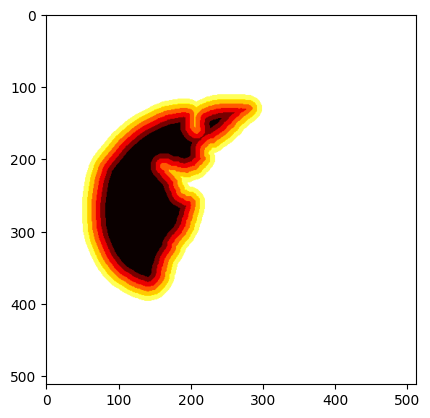

In [12]:
with open(os.path.join(data_folder, '5', 'Layer_label_map', 'GT_map_060.npy'), 'rb') as f:
    label_map = np.load(f)

plt.imshow(label_map, cmap='hot')  

phi0 (512, 512)


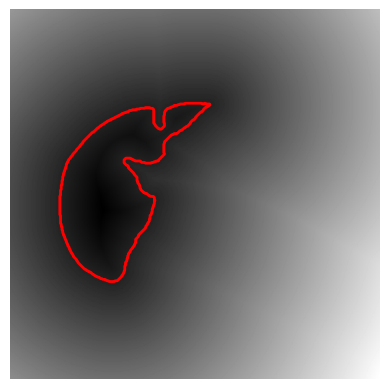

In [16]:
seg_map = np.where( label_map < 0, 1, 0)
phi0 = signed_dist = ndimage.distance_transform_edt(1 - seg_map) - ndimage.distance_transform_edt(seg_map)

print('phi0', phi0.shape)

plot_levelset(phi0)